In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from config import *
from features import *
import matplotlib.pyplot as plt
import librosa
import librosa.display
import gc
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [46]:
TEST_SIZE = 0.4
RANDOM_SEED = 191

SAMPLE_RATE = 44100 / 3

N_FFT = 2048
HOP_LENGTH = 512
N_MEL_BINS = 128
N_MFCC = 24

WINDOW = 'blackmanharris'

LEARNING_RATE = 1e-3
BATCH_SIZE = 16

In [4]:
from prepare_data import sample_train_test_songs, form_audio_data_array

train_songs, val_songs, test_songs = sample_train_test_songs(test_size=TEST_SIZE, random_seed=RANDOM_SEED, include_val=True)
print(f'Train: {len(train_songs)} songs')
print(f'Val: {len(val_songs)} songs')
print(f'Test: {len(test_songs)} songs')

Train: 35 songs
Val: 5 songs
Test: 5 songs


In [47]:
# X_train, Y_train = form_audio_data_array(song_names=train_songs, sample_rate=SAMPLE_RATE, window=WINDOW, n_fft=N_FFT,
#                                          hop_length=HOP_LENGTH, n_mel=N_MEL_BINS, n_mfcc=N_MFCC, add_axis=True)
# X_val, Y_val = form_audio_data_array(song_names=val_songs, sample_rate=SAMPLE_RATE, window=WINDOW, n_fft=N_FFT,
#                                      hop_length=HOP_LENGTH, n_mel=N_MEL_BINS, n_mfcc=N_MFCC, add_axis=True)

with open(f'tmp/X_train_{RANDOM_SEED}_{N_MFCC}.npy', 'rb') as f:
    X_train = np.load(f)
    X_train = X_train[..., np.newaxis]
with open(f'tmp/Y_train_{RANDOM_SEED}_{N_MFCC}.npy', 'rb') as f:
    Y_train = np.load(f)
    Y_train = Y_train[..., np.newaxis]
with open(f'tmp/X_val_{RANDOM_SEED}_{N_MFCC}.npy', 'rb') as f:
    X_val = np.load(f)
    X_val = X_val[..., np.newaxis]
with open(f'tmp/Y_val_{RANDOM_SEED}_{N_MFCC}.npy', 'rb') as f:
    Y_val = np.load(f)
    Y_val = Y_val[..., np.newaxis]

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(971, 24, 290, 1) (971, 1)
(126, 24, 290, 1) (126, 1)


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2 as L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [49]:
gc.collect()

22

In [50]:
model = tf.keras.Sequential([
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', input_shape=X_train.shape[1:]),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    BatchNormalization(),
    Dropout(rate=0.3),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    BatchNormalization(),
    Flatten(),
    Dense(units=7, activation='softmax')
])

optimiser = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [51]:
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
                    batch_size=BATCH_SIZE, epochs=100, callbacks=[early_stopping])

Train on 971 samples, validate on 126 samples
Epoch 1/100
971/971 [==============================] - 3s 3ms/sample - loss: 2.3685 - accuracy: 0.2389 - val_loss: 4.7771 - val_accuracy: 0.1270
Epoch 2/100
971/971 [==============================] - 2s 2ms/sample - loss: 1.7199 - accuracy: 0.3821 - val_loss: 2.7031 - val_accuracy: 0.2540
Epoch 3/100
971/971 [==============================] - 3s 3ms/sample - loss: 1.3569 - accuracy: 0.4892 - val_loss: 2.7285 - val_accuracy: 0.2302
Epoch 4/100
971/971 [==============================] - 3s 3ms/sample - loss: 1.1684 - accuracy: 0.5602 - val_loss: 2.4221 - val_accuracy: 0.2302
Epoch 5/100
971/971 [==============================] - 3s 3ms/sample - loss: 0.8138 - accuracy: 0.6735 - val_loss: 2.7414 - val_accuracy: 0.2222
Epoch 6/100
971/971 [==============================] - 3s 3ms/sample - loss: 0.6588 - accuracy: 0.7580 - val_loss: 2.2265 - val_accuracy: 0.3333
Epoch 7/100
971/971 [==============================] - 3s 3ms/sample - loss: 0.4697 

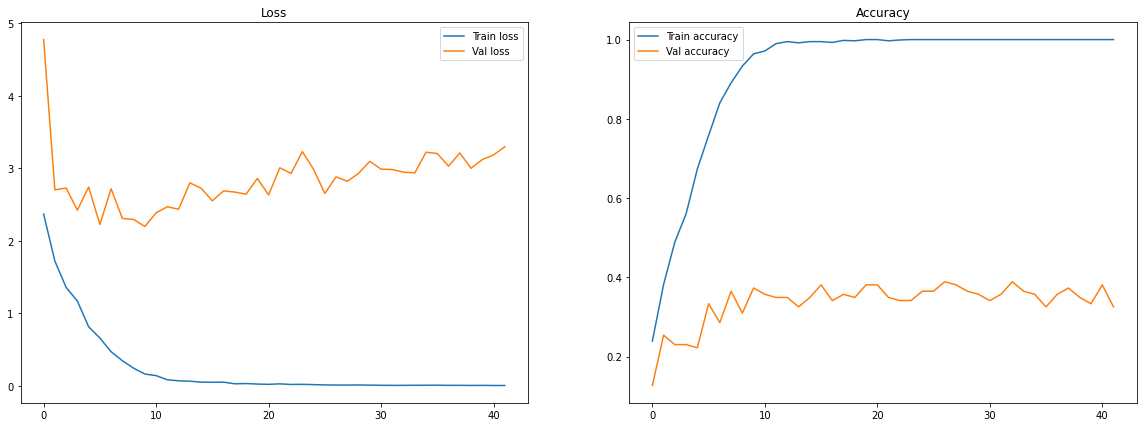

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ax[0].plot(history.history['loss'], label='Train loss')
ax[0].plot(history.history['val_loss'], label='Val loss')
ax[1].plot(history.history['accuracy'], label='Train accuracy')
ax[1].plot(history.history['val_accuracy'], label='Val accuracy')

ax[0].set_title('Loss')
ax[1].set_title('Accuracy')

ax[0].legend()
ax[1].legend()

In [53]:
model.evaluate(X_val, Y_val)

126/126 [==============================] - 0s 907us/sample - loss: 2.8828 - accuracy: 0.3889


[2.8827850402347623, 0.3888889]